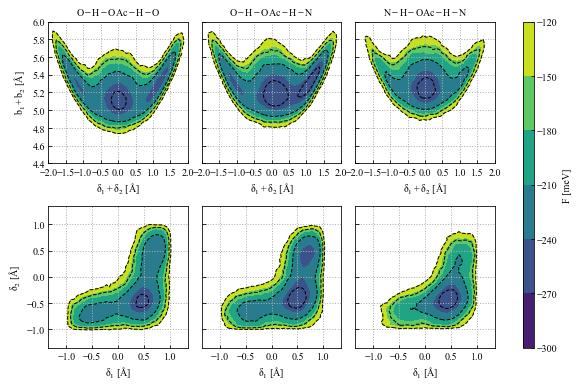

In [168]:
%matplotlib inline

from glob import glob

import matplotlib.pyplot as plt
import numpy as np

f, axs = plt.subplots(2, 3, figsize=[10, 6], sharey="row", sharex="row")

all_xax = np.concatenate(
    [np.load(fname) for fname in glob("../analyses/hbonds/nvt-*/*/xax.npy")],
    axis=0,
)


for ((ax1, ax2), name, i) in zip(axs.T, ["aaa", "aab", "bab"], [0.0, 1.0, 2.0]):
    this_xax = all_xax[all_xax[:, 0] == i]

    def hist2contour(ax, x, y):
        h, xedges, yedges = np.histogram2d(x, y, bins=40)
        pmf = - np.ma.log(h.T) * 8.617e-5 * 340 * 1000
        xbins = xedges[:-1] + (xedges[1] - xedges[0]) / 2
        ybins = yedges[:-1] + (yedges[1] - yedges[0]) / 2
        level1 = np.arange(-300, -119,30)
        level2 = np.linspace(-300,-120,5)
        
        c = ax.contourf(xbins, ybins, pmf, level1,)
        ax.contour(xbins, ybins, pmf, level2, colors="k", linewidths=1, linestyles='--')
        return c

    ax1.set_xlim(-2, 2)
    ax1.set_ylim(4.4, 6)
    ax2.set_xlim(-1.35, 1.35)
    ax2.set_ylim(-1.35, 1.35)
    ax2.set_xticks(np.arange(-1,1.1,0.5))
    ax1.set_xticks(np.arange(-2,2.1,0.5))
    ax1.set_yticks(np.arange(4.4,6.1,0.2))
    
    ax1.grid(lw=1, ls=':')
    ax2.grid(lw=1, ls=':')
    ax1.set_xlabel('$\delta_1+\delta_2~[\AA]$')
    ax2.set_xlabel('$\delta_1~[\AA]$')
    if i==0.:
        ax2.set_ylabel('$\delta_2~[\AA]$')
        ax1.set_ylabel('$b_1+b_2~[\AA]$')
    
    c = hist2contour(ax1, this_xax[:, 1:] @ [-1, 1, -1, 1], this_xax[:, 1:] @ [1, 1, 1, 1])
    hist2contour(ax2, this_xax[:, 1:] @ [-1, 1, 0, 0], this_xax[:, 1:] @ [0, 0, -1, 1])

plt.subplots_adjust(wspace=0.1, hspace=0.3)
f.colorbar(c, ax=axs.flatten().tolist(), aspect=30, label='F [meV]')
axs[0,0].set_title('$O-H-OAc-H-O$',fontsize=10)
axs[0,1].set_title('$O-H-OAc-H-N$',fontsize=10)
axs[0,2].set_title('$N-H-OAc-H-N$',fontsize=10)
plt.savefig('pt_pmf.pdf')

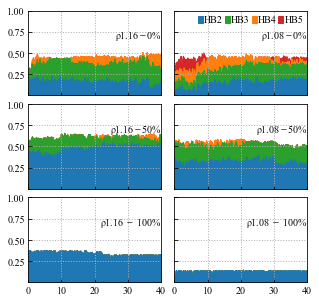

In [205]:
from scipy.signal import savgol_filter

f, axs = plt.subplots(3,2, figsize=[5,5], sharex=True, sharey=True)
stride = 10

for rho, col, t1 in zip(['rho1.1551', 'rho1.0753'], axs.T, [r'$\rho1.16',r'$\rho1.08']):
    for tag, ax, t2 in zip(['a32b32i0','a16b16i16','a0b0i32'], col, ['-0\%$', '-50\%$', '~-~100\%$']):
        ener = np.concatenate([np.loadtxt(f'../trajs/cp2k/nvt-{seg}-{seg+10}ps/hoac-c1im-{tag}-{rho}/cp2k-md-1.ener') for seg in [0,10,20,30]],axis=0)
        traj = np.concatenate([np.load(f'../analyses/hbonds/nvt-{seg}-{seg+10}ps/hoac-c1im-{tag}-{rho}/pop.npy') for seg in [0,10,20,30]],axis=0)
        traj = traj[::stride]
        ener = ener[::stride]
        t = ener[:,1]/1000
        pot = ener[:,4]/640*27.2114
        ax.text(1,0.7, t1+t2,transform=ax.transAxes, va='center', ha='right')
        hbpop = traj[:,4:].cumsum(axis=1)/64.
        hbpop = np.apply_along_axis(lambda m: savgol_filter(m, 101, 3), axis=0, arr=hbpop)
        handles = [ax.fill_between(t, x, color=color, alpha=1) for x, color in 
                   list(zip(hbpop.T, ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']))[::-1]]
        ax.grid(lw=1, ls=':')
        
axs[0,1].legend(handles[::-1], [f'HB{i+2}' for i in range(len(handles))], 
                handlelength=0.5, ncol=4, columnspacing=0.2, handletextpad=0.1, borderaxespad=0)
ax.set_ylim(0.001,1)
ax.set_xlim(0,40)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('hbnet.pdf')